In [27]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from pathlib import Path

In [28]:
batch_size = 32
img_height = 256
img_width = 256
epochs = 20
BASE_DATA_DIR = "./dataset/"

AUTOTUNE = tf.data.AUTOTUNE

In [29]:
from struct import unpack

marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}

class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break        

for path in Path(BASE_DATA_DIR).glob("**/*"):
    if(not path.is_file()):
        continue
    image = JPEG(path) 

    try:
        image.decode()
    except:
        print(path)
        path.unlink()

In [30]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [31]:
histories = {}
classes = {}

In [32]:
def create_model(data_dir,name):
    train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.05,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

    val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.05,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

    class_names = train_ds.class_names

    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)



    model = Sequential([
        data_augmentation,
        layers.Rescaling(1./255),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.1),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.1),
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
    
    histories[name] = model.fit(
        train_ds,
        batch_size=batch_size,
        validation_data=val_ds,
        epochs=epochs
    )

    classes[name] = class_names

    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # Save the model.
    with open(f"models/{name}.tflite", 'wb') as f:
        f.write(tflite_model)

In [33]:
for path in Path(BASE_DATA_DIR).iterdir():
    create_model(path,path.name)

Found 1736 files belonging to 34 classes.
Using 1650 files for training.
Found 1736 files belonging to 34 classes.
Using 86 files for validation.
Epoch 1/20
52/52 [==============================] - 14s 234ms/step - loss: 3.3926 - accuracy: 0.0655 - val_loss: 3.3141 - val_accuracy: 0.1395
Epoch 2/20
52/52 [==============================] - 11s 212ms/step - loss: 3.2048 - accuracy: 0.1073 - val_loss: 3.1529 - val_accuracy: 0.0814
Epoch 3/20
52/52 [==============================] - 11s 213ms/step - loss: 3.1369 - accuracy: 0.1115 - val_loss: 3.1337 - val_accuracy: 0.0698
Epoch 4/20
52/52 [==============================] - 11s 214ms/step - loss: 3.0738 - accuracy: 0.1176 - val_loss: 3.0789 - val_accuracy: 0.1279
Epoch 5/20
52/52 [==============================] - 11s 216ms/step - loss: 3.0322 - accuracy: 0.1291 - val_loss: 3.1049 - val_accuracy: 0.1395
Epoch 6/20
52/52 [==============================] - 11s 219ms/step - loss: 2.9246 - accuracy: 0.1582 - val_loss: 3.0026 - val_accuracy: 0.1

INFO:tensorflow:Assets written to: C:\Users\karth\AppData\Local\Temp\tmp7jctyh4z\assets


Found 873 files belonging to 12 classes.
Using 830 files for training.
Found 873 files belonging to 12 classes.
Using 43 files for validation.
Epoch 1/20
26/26 [==============================] - 7s 223ms/step - loss: 2.4060 - accuracy: 0.1916 - val_loss: 2.0327 - val_accuracy: 0.3488
Epoch 2/20
26/26 [==============================] - 6s 223ms/step - loss: 2.0848 - accuracy: 0.2711 - val_loss: 1.7710 - val_accuracy: 0.4884
Epoch 3/20
26/26 [==============================] - 6s 229ms/step - loss: 1.8526 - accuracy: 0.3542 - val_loss: 1.5651 - val_accuracy: 0.4186
Epoch 4/20
26/26 [==============================] - 6s 225ms/step - loss: 1.7043 - accuracy: 0.4181 - val_loss: 1.4691 - val_accuracy: 0.5581
Epoch 5/20
26/26 [==============================] - 6s 223ms/step - loss: 1.5565 - accuracy: 0.4602 - val_loss: 1.3362 - val_accuracy: 0.4884
Epoch 6/20
26/26 [==============================] - 6s 225ms/step - loss: 1.4299 - accuracy: 0.5277 - val_loss: 1.1605 - val_accuracy: 0.6512
Epoch

INFO:tensorflow:Assets written to: C:\Users\karth\AppData\Local\Temp\tmpmf90z0g9\assets


Found 214 files belonging to 5 classes.
Using 204 files for training.
Found 214 files belonging to 5 classes.
Using 10 files for validation.
Epoch 1/20
7/7 [==============================] - 3s 216ms/step - loss: 1.0689 - accuracy: 0.6961 - val_loss: 0.4452 - val_accuracy: 0.9000
Epoch 2/20
7/7 [==============================] - 1s 197ms/step - loss: 0.8157 - accuracy: 0.7892 - val_loss: 1.0740 - val_accuracy: 0.9000
Epoch 3/20
7/7 [==============================] - 1s 198ms/step - loss: 0.7098 - accuracy: 0.7892 - val_loss: 0.3998 - val_accuracy: 0.9000
Epoch 4/20
7/7 [==============================] - 1s 196ms/step - loss: 0.5518 - accuracy: 0.7892 - val_loss: 0.2510 - val_accuracy: 0.9000
Epoch 5/20
7/7 [==============================] - 1s 197ms/step - loss: 0.4155 - accuracy: 0.8284 - val_loss: 0.2233 - val_accuracy: 1.0000
Epoch 6/20
7/7 [==============================] - 1s 202ms/step - loss: 0.3534 - accuracy: 0.8824 - val_loss: 0.1206 - val_accuracy: 1.0000
Epoch 7/20
7/7 [===

INFO:tensorflow:Assets written to: C:\Users\karth\AppData\Local\Temp\tmpfzwfwvdf\assets


Found 431 files belonging to 9 classes.
Using 410 files for training.
Found 431 files belonging to 9 classes.
Using 21 files for validation.
Epoch 1/20
13/13 [==============================] - 4s 223ms/step - loss: 1.8960 - accuracy: 0.3561 - val_loss: 1.9494 - val_accuracy: 0.1905
Epoch 2/20
13/13 [==============================] - 3s 214ms/step - loss: 1.5484 - accuracy: 0.3488 - val_loss: 1.8795 - val_accuracy: 0.2857
Epoch 3/20
13/13 [==============================] - 3s 214ms/step - loss: 1.4668 - accuracy: 0.3829 - val_loss: 1.8208 - val_accuracy: 0.2857
Epoch 4/20
13/13 [==============================] - 3s 215ms/step - loss: 1.4351 - accuracy: 0.4293 - val_loss: 1.7895 - val_accuracy: 0.2857
Epoch 5/20
13/13 [==============================] - 3s 221ms/step - loss: 1.4001 - accuracy: 0.4317 - val_loss: 1.7664 - val_accuracy: 0.3810
Epoch 6/20
13/13 [==============================] - 3s 221ms/step - loss: 1.4009 - accuracy: 0.4488 - val_loss: 1.9877 - val_accuracy: 0.3333
Epoch 7

INFO:tensorflow:Assets written to: C:\Users\karth\AppData\Local\Temp\tmp1spxi1wr\assets


Found 114 files belonging to 2 classes.
Using 109 files for training.
Found 114 files belonging to 2 classes.
Using 5 files for validation.
Epoch 1/20
4/4 [==============================] - 2s 217ms/step - loss: 0.9945 - accuracy: 0.6514 - val_loss: 0.4879 - val_accuracy: 1.0000
Epoch 2/20
4/4 [==============================] - 1s 184ms/step - loss: 0.5748 - accuracy: 0.7248 - val_loss: 0.4749 - val_accuracy: 1.0000
Epoch 3/20
4/4 [==============================] - 1s 184ms/step - loss: 0.5820 - accuracy: 0.7248 - val_loss: 0.4935 - val_accuracy: 1.0000
Epoch 4/20
4/4 [==============================] - 1s 181ms/step - loss: 0.5445 - accuracy: 0.7248 - val_loss: 0.3380 - val_accuracy: 1.0000
Epoch 5/20
4/4 [==============================] - 1s 183ms/step - loss: 0.5484 - accuracy: 0.7248 - val_loss: 0.4013 - val_accuracy: 1.0000
Epoch 6/20
4/4 [==============================] - 1s 185ms/step - loss: 0.5101 - accuracy: 0.7431 - val_loss: 0.3333 - val_accuracy: 1.0000
Epoch 7/20
4/4 [====

INFO:tensorflow:Assets written to: C:\Users\karth\AppData\Local\Temp\tmpddbz_7dw\assets


Found 740 files belonging to 6 classes.
Using 703 files for training.
Found 740 files belonging to 6 classes.
Using 37 files for validation.
Epoch 1/20
22/22 [==============================] - 7s 226ms/step - loss: 1.8349 - accuracy: 0.2560 - val_loss: 1.6758 - val_accuracy: 0.2432
Epoch 2/20
22/22 [==============================] - 5s 216ms/step - loss: 1.6764 - accuracy: 0.2717 - val_loss: 1.5743 - val_accuracy: 0.3243
Epoch 3/20
22/22 [==============================] - 5s 220ms/step - loss: 1.6322 - accuracy: 0.3300 - val_loss: 1.5588 - val_accuracy: 0.3243
Epoch 4/20
22/22 [==============================] - 5s 221ms/step - loss: 1.6164 - accuracy: 0.3385 - val_loss: 1.4809 - val_accuracy: 0.4324
Epoch 5/20
22/22 [==============================] - 5s 221ms/step - loss: 1.5518 - accuracy: 0.3798 - val_loss: 1.5139 - val_accuracy: 0.5676
Epoch 6/20
22/22 [==============================] - 5s 225ms/step - loss: 1.5404 - accuracy: 0.3841 - val_loss: 1.5022 - val_accuracy: 0.4054
Epoch 7

INFO:tensorflow:Assets written to: C:\Users\karth\AppData\Local\Temp\tmp8_eji12y\assets


Found 661 files belonging to 9 classes.
Using 628 files for training.
Found 661 files belonging to 9 classes.
Using 33 files for validation.
Epoch 1/20
20/20 [==============================] - 6s 227ms/step - loss: 2.1389 - accuracy: 0.2229 - val_loss: 1.9628 - val_accuracy: 0.2727
Epoch 2/20
20/20 [==============================] - 4s 211ms/step - loss: 1.9591 - accuracy: 0.2691 - val_loss: 1.9442 - val_accuracy: 0.2424
Epoch 3/20
20/20 [==============================] - 4s 215ms/step - loss: 1.8594 - accuracy: 0.3025 - val_loss: 1.8489 - val_accuracy: 0.3030
Epoch 4/20
20/20 [==============================] - 4s 218ms/step - loss: 1.7716 - accuracy: 0.3296 - val_loss: 1.8485 - val_accuracy: 0.3030
Epoch 5/20
20/20 [==============================] - 4s 216ms/step - loss: 1.6298 - accuracy: 0.4061 - val_loss: 1.8425 - val_accuracy: 0.3030
Epoch 6/20
20/20 [==============================] - 4s 217ms/step - loss: 1.5338 - accuracy: 0.4411 - val_loss: 1.8852 - val_accuracy: 0.3030
Epoch 7

INFO:tensorflow:Assets written to: C:\Users\karth\AppData\Local\Temp\tmpuoy4zi0y\assets


Found 174 files belonging to 2 classes.
Using 166 files for training.
Found 174 files belonging to 2 classes.
Using 8 files for validation.
Epoch 1/20
6/6 [==============================] - 3s 209ms/step - loss: 1.6237 - accuracy: 0.5663 - val_loss: 0.6657 - val_accuracy: 0.7500
Epoch 2/20
6/6 [==============================] - 1s 183ms/step - loss: 0.6583 - accuracy: 0.5663 - val_loss: 0.6730 - val_accuracy: 0.7500
Epoch 3/20
6/6 [==============================] - 1s 220ms/step - loss: 0.4870 - accuracy: 0.8313 - val_loss: 0.3740 - val_accuracy: 1.0000
Epoch 4/20
6/6 [==============================] - 1s 191ms/step - loss: 0.3043 - accuracy: 0.8675 - val_loss: 0.1752 - val_accuracy: 1.0000
Epoch 5/20
6/6 [==============================] - 1s 186ms/step - loss: 0.2956 - accuracy: 0.8795 - val_loss: 0.2420 - val_accuracy: 1.0000
Epoch 6/20
6/6 [==============================] - 1s 185ms/step - loss: 0.1777 - accuracy: 0.9277 - val_loss: 0.1595 - val_accuracy: 1.0000
Epoch 7/20
6/6 [====

INFO:tensorflow:Assets written to: C:\Users\karth\AppData\Local\Temp\tmpt9yb_6dl\assets


animals


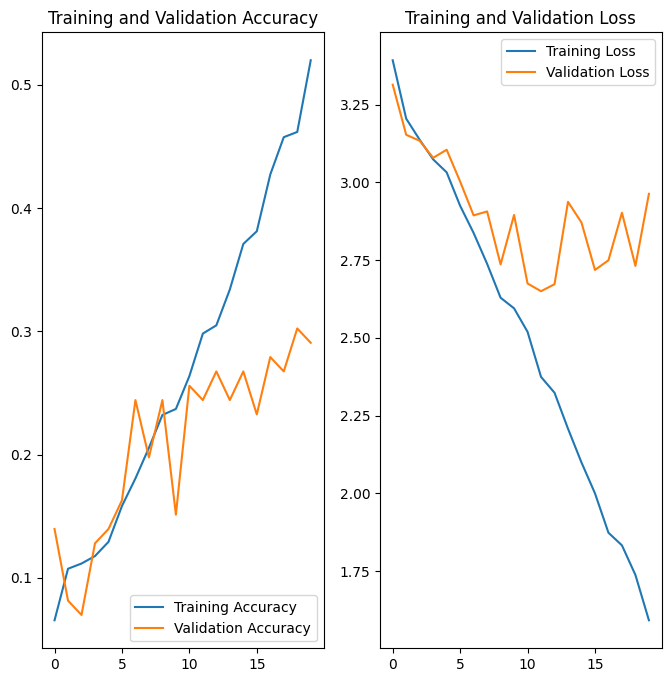

birds


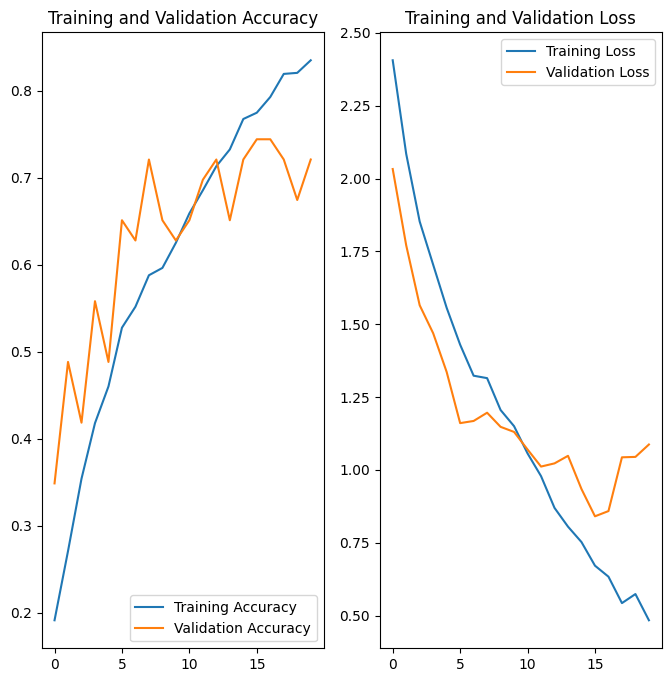

characters


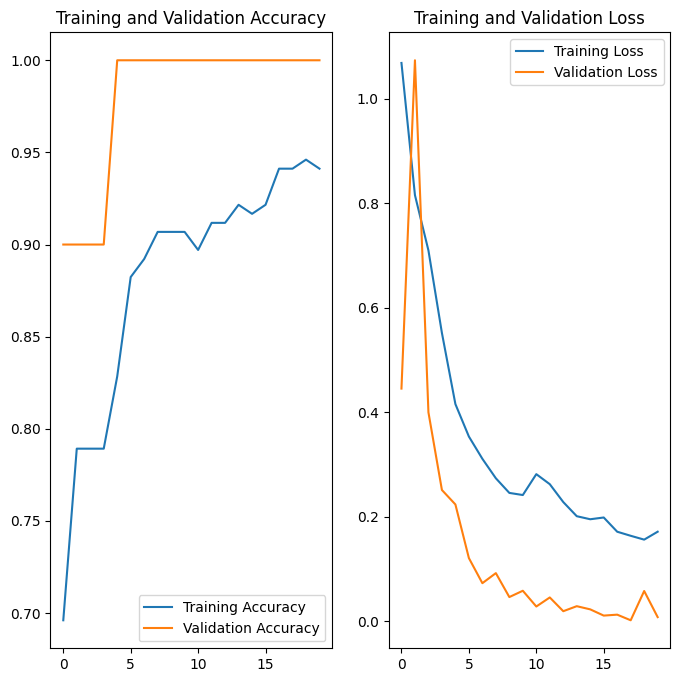

dinosaurs


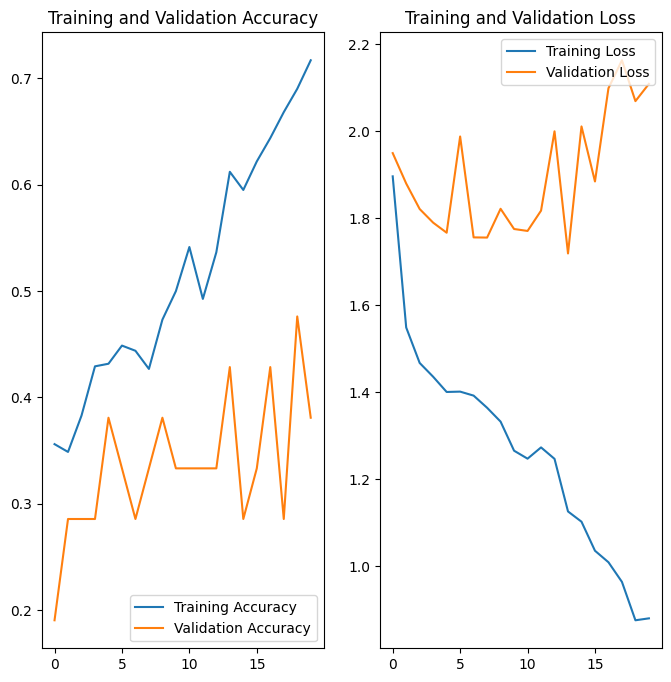

fictional


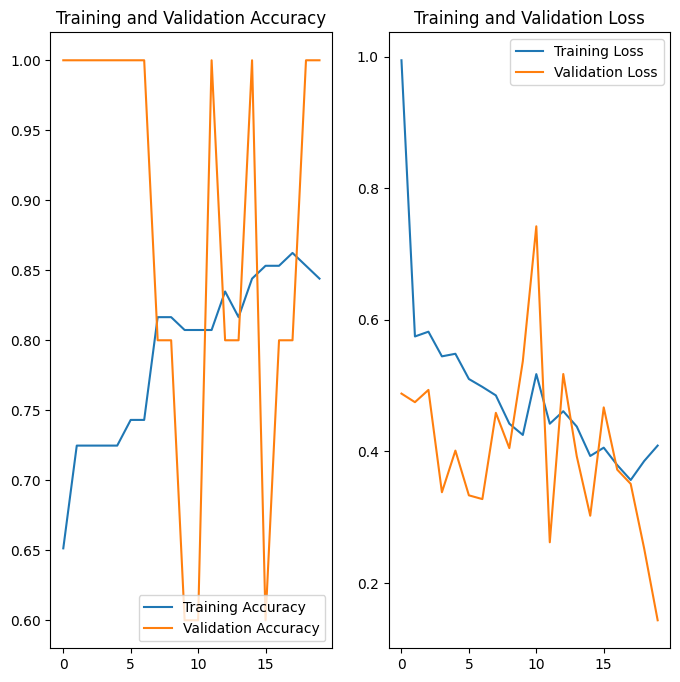

insects


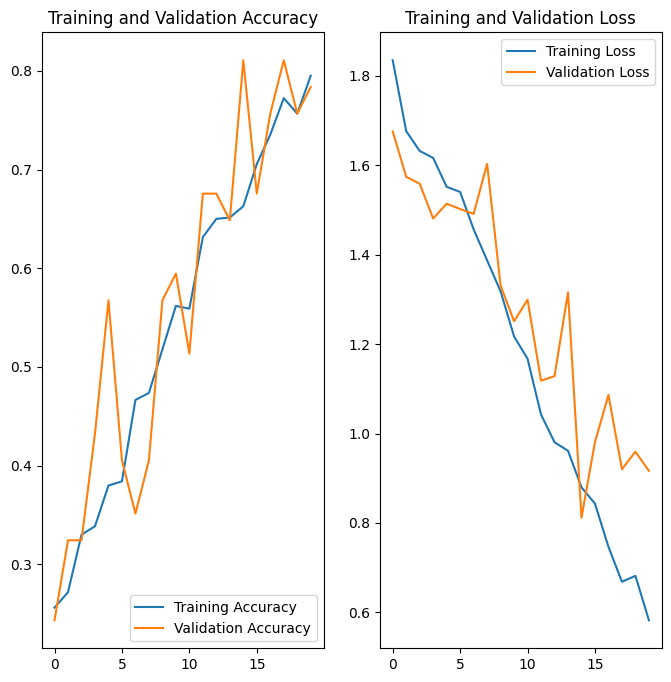

objects


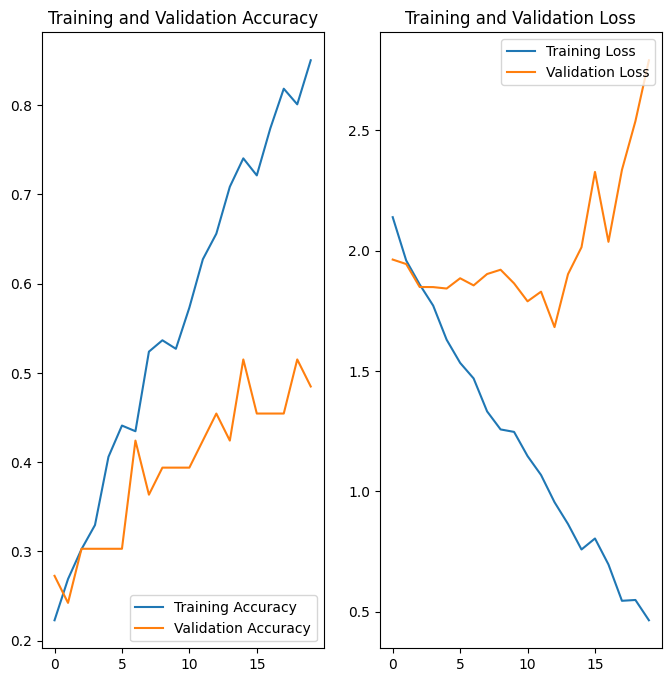

shapes


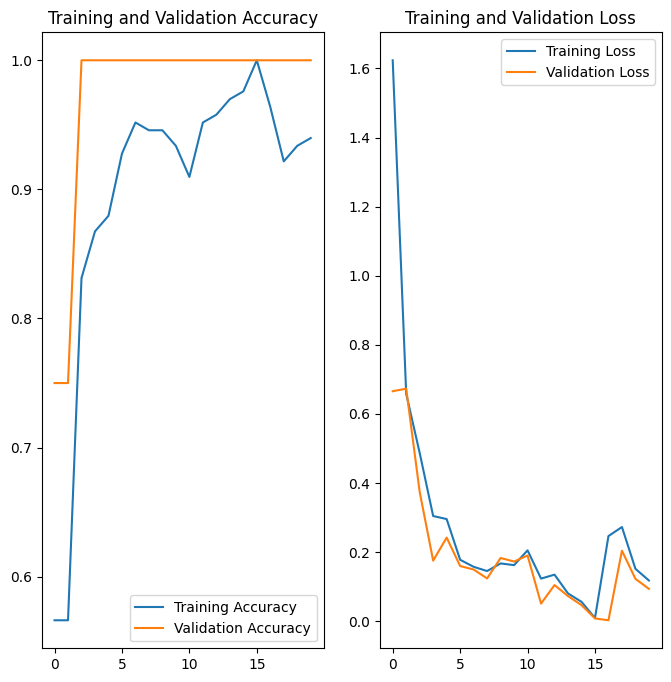

In [37]:
def history_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

for name,history in histories.items():
    print(name)
    history_plot(history)

In [39]:
import json
with open("classes.json","w") as fh:
    json.dump(classes,fh,indent=4)